In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# for graphing
import matplotlib
import matplotlib.pyplot as plt

# machine learning
import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import xgboost
from xgboost import XGBClassifier

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get package versions
print('numpy version is:{}'.format(np.__version__))
print('pandas version is:{}'.format(pd.__version__))
print('matplotlib version is:{}'.format(matplotlib.__version__))
print('scikit-learn version is:{}'.format(sklearn.__version__))
print('xgboost version is:{}'.format(xgboost.__version__))


numpy version is:1.26.4
pandas version is:2.2.3
matplotlib version is:3.7.2
scikit-learn version is:1.2.2
xgboost version is:2.0.3


In [3]:
# load/read training data
train_df= pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")

# look at the training data
print(train_df.head())
print('shape of training data is:{}'.format(train_df.shape))

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
sh

In [4]:
# look at null values for training data
train_df.isnull().sum().sort_values()

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

not that many null values.  try to impute

In [5]:
# read/load test data
test_df= pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# look at test data
print(test_df.head())
print('shape of test df is:{}'.format(test_df.shape))

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  
shape of test df is:(4277, 13)


In [6]:
# look at null for test df
test_df.isnull().sum().sort_values()

PassengerId       0
VRDeck           80
RoomService      82
HomePlanet       87
Age              91
Destination      92
CryoSleep        93
VIP              93
Name             94
ShoppingMall     98
Cabin           100
Spa             101
FoodCourt       106
dtype: int64

In [7]:
# save test passenger id
test_id= test_df['PassengerId']

# drop passenger id and name from training 
train_df.drop(columns= ['PassengerId', 'Name'], inplace= True)
print('new training dataframe')
print(train_df.head())

# drop passenger id and name from test
test_df.drop(columns= ['PassengerId', 'Name'], inplace= True)
print('\n new test dataframe')
print(test_df.head())

new training dataframe
  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0   
1      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0   
2     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0   
3     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0   
4      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported  
0        0.0           0.0     0.0     0.0        False  
1        9.0          25.0   549.0    44.0         True  
2     3576.0           0.0  6715.0    49.0        False  
3     1283.0         371.0  3329.0   193.0        False  
4       70.0         151.0   565.0     2.0         True  

 new test dataframe
  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0      Earth      True  G/3/S  TRAPPIST-1e  27.0  False          0.0   
1      Earth     False  F/4/S  

In [8]:
# look at statistics for training numeric columns
train_num_col= sorted(train_df.select_dtypes(include= np.number).columns.tolist())

train_df[train_num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


FoodCourt, RoomService, ShoppingMall, Spa and VRDeck are all very skewed.

In [9]:
# look at statistics for training categorical
train_str_col= sorted(train_df.select_dtypes(exclude= np.number).columns.tolist())

train_df[train_str_col].describe().T

,count,unique,top,freq
Cabin,8494,6560,G/734/S,8
CryoSleep,8476,2,False,5439
Destination,8511,3,TRAPPIST-1e,5915
HomePlanet,8492,3,Earth,4602
Transported,8693,2,True,4378
VIP,8490,2,False,8291


Cabin has a lot of different values, so I will drop it?  it would add a lot of things if one hot encoded.  

In [10]:
# drop columns
train_df.drop(['Cabin', 'VIP'], axis= 1, inplace= True)
test_df.drop(['Cabin', 'VIP'], axis= 1, inplace= True)

Dropped VIP because decision tree showed low feature importance and dropping it maintained accuracy score for Random Forest and XGBoost.

In [11]:
# make histogram and boxplot function
def graph_fn(df1, col1, bin1= None):
    fig1, ax1= plt.subplots(1, 2, figsize= (8, 5), gridspec_kw= {'width_ratios':[2, 1]})
    # get average
    avg1= df1[col1].mean()
    # get median
    mid1= df1[col1].median()
    # customize histogram
    ax1[0].hist(df1[col1], edgecolor= 'k', bins= bin1)
    ax1[0].axvline(avg1, linewidth= 2, color= 'green', label= 'Mean')
    ax1[0].axvline(mid1, linewidth= 2, color= 'violet', label= 'Median')
    ax1[0].set_title(col1)
    # customize boxplot
    df1.boxplot(column= col1, ax= ax1[1])
    ax1[1].axhline(avg1, linewidth= 2, color= 'green', label= 'Mean')
    ax1[1].axhline(mid1, linewidth= 2, color= 'violet', label= 'Median')
    return fig1, ax1

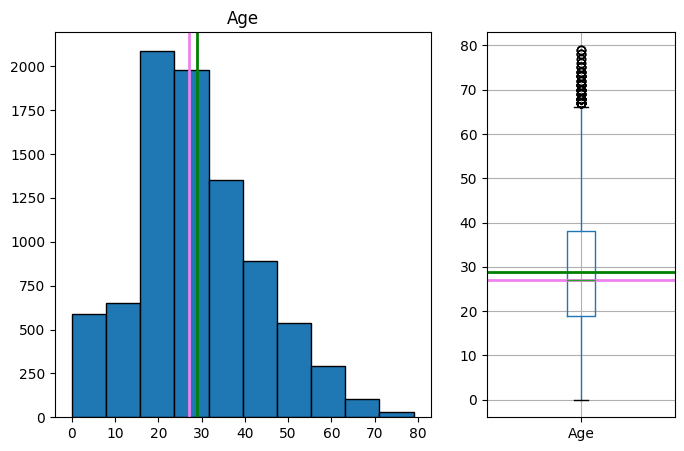

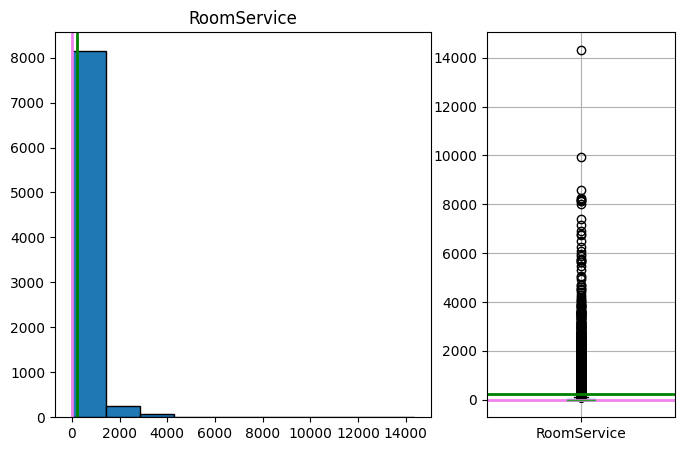

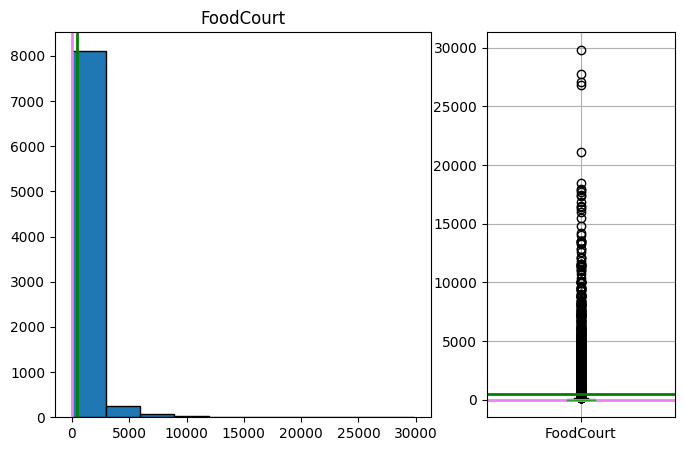

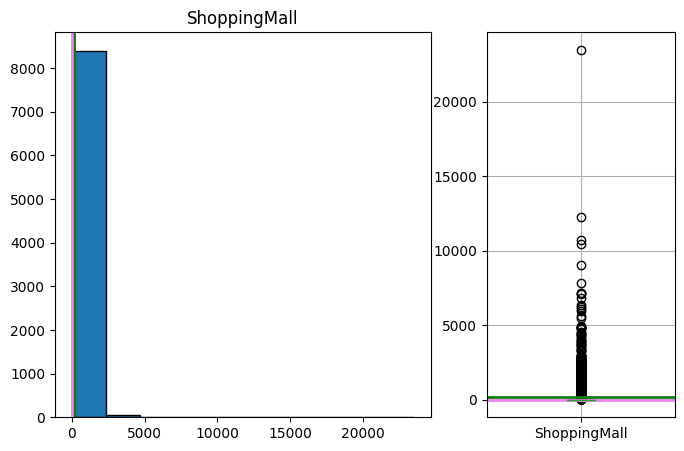

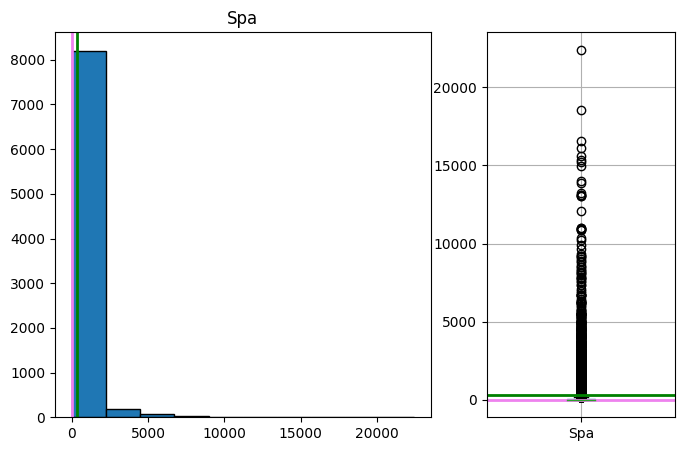

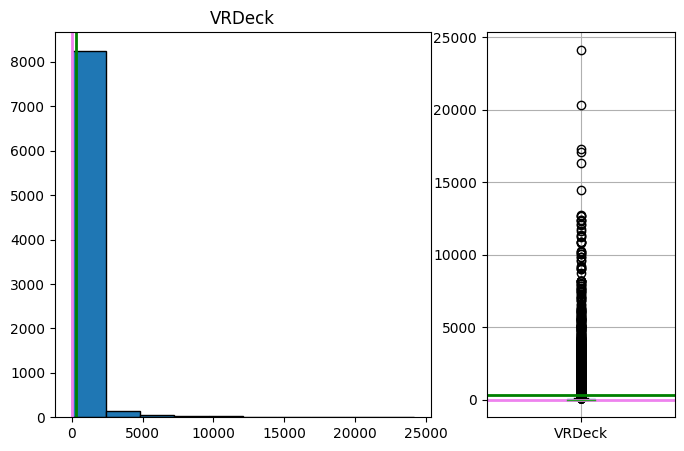

In [12]:
# plot the numeric columns for training
train_num_col= train_df.select_dtypes(include= np.number).columns.tolist()
for k in range(len(train_num_col)):
    graph_fn(train_df, train_num_col[k])

Highly right skewed data: VRDeck, ShoppingMall, Spa, ShoppingMall, and FoodCourt

In [13]:
#split the data into feature and target
y1= train_df['Transported']
x1= train_df.drop(['Transported'], axis= 1)

# split data into training and validation
xtrain, xval, ytrain, yval= train_test_split(x1, y1, test_size= 0.2, shuffle= True, random_state= 24)

# reset the index for all dataframes
xtrain= xtrain.reset_index(drop= True)
ytrain= ytrain.reset_index(drop= True)
xval= xval.reset_index(drop= True)
yval= yval.reset_index(drop= True)

# look at size of dataframes
print('shape of xtrain is:{}'.format(xtrain.shape))
print('shape of xval is:{}'.format(xval.shape))
print('shape of ytrain is:{}'.format(ytrain.shape))
print('shape of yval is:{}'.format(yval.shape))

shape of xtrain is:(6954, 9)
shape of xval is:(1739, 9)
shape of ytrain is:(6954,)
shape of yval is:(1739,)


In [14]:
# check number of null in training
print('xtrain number of null is:{}'.format(xtrain.isnull().sum().sum()))

xtrain number of null is:1396


In [15]:
# find the numeric columns
train_num_col= sorted(xtrain.select_dtypes(include= np.number).columns.tolist())

# impute the numeric columns with median
for i in train_num_col:
    mid1= xtrain[i].median()
    xtrain[i].fillna(mid1, inplace= True)
    xval[i].fillna(mid1, inplace= True)


In [16]:
# scale numeric columns 

# initialize scaler
scaler= MinMaxScaler()

# scale the training numeric columns
xtrain_scale= scaler.fit_transform(xtrain[train_num_col])
xtrain_scale= pd.DataFrame(xtrain_scale, columns= train_num_col)
# scale the validation numeric columns
xval_scale= scaler.transform(xval[train_num_col])
xval_scale= pd.DataFrame(xval_scale, columns= train_num_col)

# look at scaled training data
print('scaled xtrain')
print(xtrain_scale.head())

scaled xtrain
        Age  FoodCourt  RoomService  ShoppingMall       Spa    VRDeck
0  0.810127   0.000134      0.00000      0.000000  0.276687  0.025774
1  0.329114   0.161339      0.00000      0.000000  0.043779  0.085112
2  0.708861   0.058699      0.01782      0.000000  0.014905  0.063772
3  0.772152   0.000000      0.00000      0.000000  0.000000  0.000000
4  0.265823   0.000000      0.25693      0.028809  0.000000  0.000787


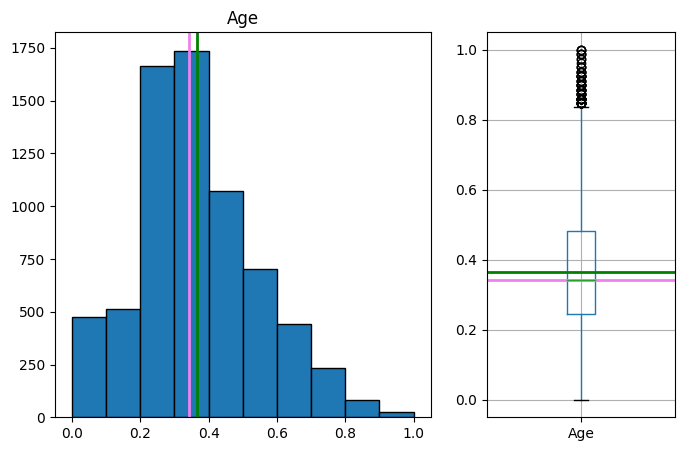

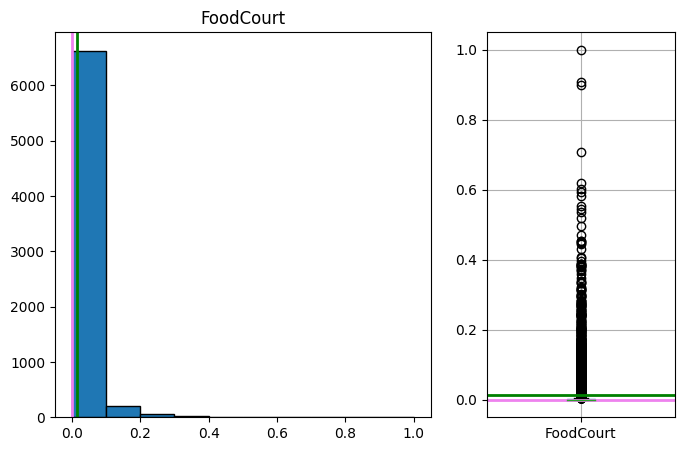

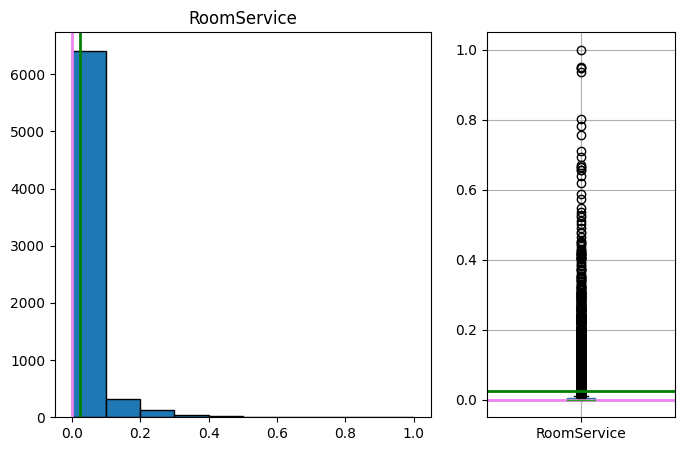

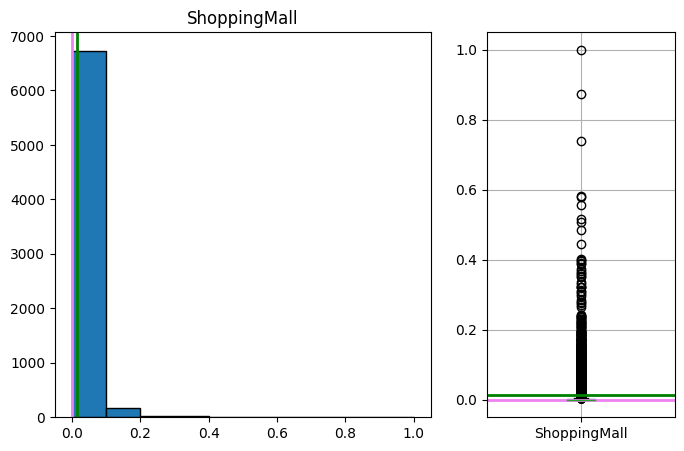

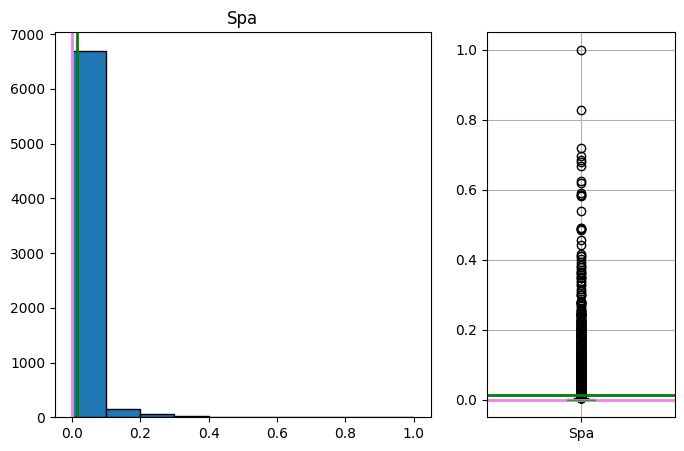

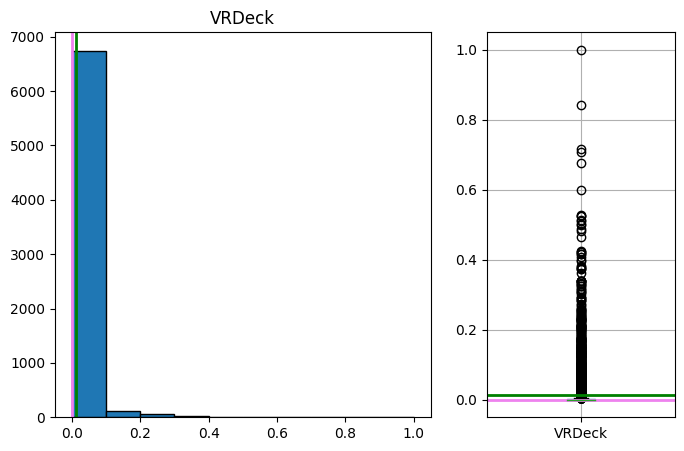

In [17]:
# plot the scaled numeric columns for training

for i in range(len(train_num_col)):
    graph_fn(xtrain_scale, train_num_col[i])

In [18]:
# find the categorical columns
train_str_col= sorted(xtrain.select_dtypes(exclude= np.number).columns.tolist())

# impute the categorical columns with mode
# initialize the imputer
imputer= SimpleImputer(strategy= 'most_frequent')
# impute training categorical columns
xtrain_impute= imputer.fit_transform(xtrain[train_str_col])
xtrain_impute= pd.DataFrame(xtrain_impute, columns= imputer.get_feature_names_out()).reset_index(drop= True)


# impute validation categorical colummns
xval_impute= imputer.transform(xval[train_str_col])
xval_impute= pd.DataFrame(xval_impute, columns= imputer.get_feature_names_out()).reset_index(drop= True)


In [19]:
# check null for training
print('remaining null in training dataframe is:{}'.format(xtrain_impute.isnull().sum().sum()))

remaining null in training dataframe is:0


In [20]:
# one hot encode categorical

# initialize one hot encoder
encoder= OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

# encode training
xtrain_encode= encoder.fit_transform(xtrain_impute)
xtrain_encode= pd.DataFrame(xtrain_encode, columns= encoder.get_feature_names_out())
# combine numeric and categorical
xtrain_done= pd.concat([xtrain_scale, xtrain_encode], axis= 1)

# encode validation
xval_encode= encoder.transform(xval_impute)
xval_encode= pd.DataFrame(xval_encode, columns= encoder.get_feature_names_out())
# combine numeric and categorical
xval_done= pd.concat([xval_scale, xval_encode], axis= 1)

# look at training dataframe
print('training dataframe')
print(xtrain_done.head())

# look at validation dataframe
print('-'*80)
print('validation dataframe')
print(xval_done.head())

training dataframe
        Age  FoodCourt  RoomService  ShoppingMall       Spa    VRDeck  \
0  0.810127   0.000134      0.00000      0.000000  0.276687  0.025774   
1  0.329114   0.161339      0.00000      0.000000  0.043779  0.085112   
2  0.708861   0.058699      0.01782      0.000000  0.014905  0.063772   
3  0.772152   0.000000      0.00000      0.000000  0.000000  0.000000   
4  0.265823   0.000000      0.25693      0.028809  0.000000  0.000787   

   CryoSleep_False  CryoSleep_True  Destination_55 Cancri e  \
0              1.0             0.0                      0.0   
1              1.0             0.0                      0.0   
2              1.0             0.0                      0.0   
3              0.0             1.0                      0.0   
4              1.0             0.0                      0.0   

   Destination_PSO J318.5-22  Destination_TRAPPIST-1e  HomePlanet_Earth  \
0                        0.0                      1.0               0.0   
1            

In [21]:
# function to train, predict and evaluate

def allthings_fn(name1, model1, xtrain1, ytrain1, xval1, yval1):
    # fit the model
    model1.fit(xtrain1, ytrain1)

    # predict training
    y_pred_train= model1.predict(xtrain1)
    # predict validation
    y_pred_val= model1.predict(xval1)

    # evaluate accuracy and f1 score
    train_acc= accuracy_score(ytrain1, y_pred_train)
    train_f1= f1_score(ytrain1, y_pred_train)
    val_acc= accuracy_score(yval1, y_pred_val)
    val_f1= f1_score(yval1, y_pred_val)
    # list of metrics training and validation
    eval_list= [name1, train_acc, train_f1, val_acc, val_f1]
    # make summary dataframe
    df1= pd.DataFrame([eval_list], columns= ['Name', 'Train_accuracy', 'Train_F1', 'Val_accuracy', 'Val_F1'])

    # classification report
    report1= classification_report(yval1, y_pred_val) 

    # confusion matrix
    matrix1= ConfusionMatrixDisplay.from_predictions(yval1, y_pred_val, display_labels= [False, True])

    return df1, report1, matrix1
    

     Name  Train_accuracy  Train_F1  Val_accuracy    Val_F1
0  logreg        0.764452  0.752044      0.775733  0.763062
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.75      0.82      0.79       874
        True       0.80      0.73      0.76       865

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

--------------------------------------------------------------------------------


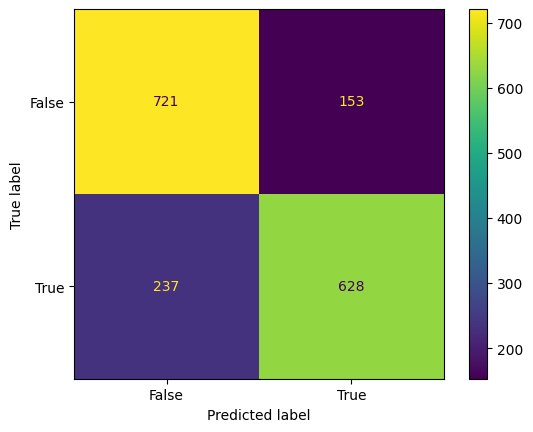

In [22]:
# Classification with Logistic Regression

reg1= LogisticRegression(random_state= 24)

df0, report0, matrix0= allthings_fn("logreg", reg1, xtrain_done, ytrain, xval_done, yval)

# look at model performance
print(df0)

print('-'*80)
print(report0)

print('-'*80)
print(matrix0)

            Name  Train_accuracy  Train_F1  Val_accuracy    Val_F1
0         logreg        0.764452  0.752044      0.775733  0.763062
0  decision tree        0.930112  0.933461      0.751581  0.763676
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.78      0.70      0.74       874
        True       0.72      0.81      0.76       865

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739

--------------------------------------------------------------------------------


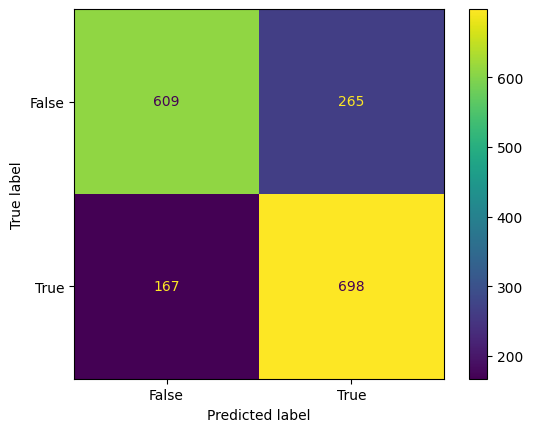

In [23]:
# Classification with Decision Tree

dtree1= DecisionTreeClassifier(random_state= 24, criterion= 'entropy')

df1, report1, matrix1= allthings_fn("decision tree", dtree1, xtrain_done, ytrain, xval_done, yval)

df_good= pd.concat([df0, df1], axis= 0)

# look at model performance
print(df_good)

print('-'*80)
print(report1)

print('-'*80)
print(matrix1)

Decision tree is overfit

In [24]:
# decision tree look at feature importance
import1= dtree1.feature_importances_

import_df= pd.DataFrame(import1, index= xtrain_done.columns)

import_df= import_df.sort_values(by= 0, ascending= False)

print(import_df)

                                  0
CryoSleep_False            0.197509
Age                        0.138593
VRDeck                     0.130577
FoodCourt                  0.120672
Spa                        0.115103
RoomService                0.112439
ShoppingMall               0.081735
HomePlanet_Earth           0.057110
HomePlanet_Europa          0.014901
Destination_TRAPPIST-1e    0.010475
HomePlanet_Mars            0.008947
Destination_55 Cancri e    0.006569
Destination_PSO J318.5-22  0.005371
CryoSleep_True             0.000000


            Name  Train_accuracy  Train_F1  Val_accuracy    Val_F1
0         logreg        0.764452  0.752044      0.775733  0.763062
0  decision tree        0.930112  0.933461      0.751581  0.763676
0  Random Forest        0.930112  0.933967      0.795860  0.798181
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.81      0.78      0.79       874
        True       0.79      0.81      0.80       865

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

--------------------------------------------------------------------------------


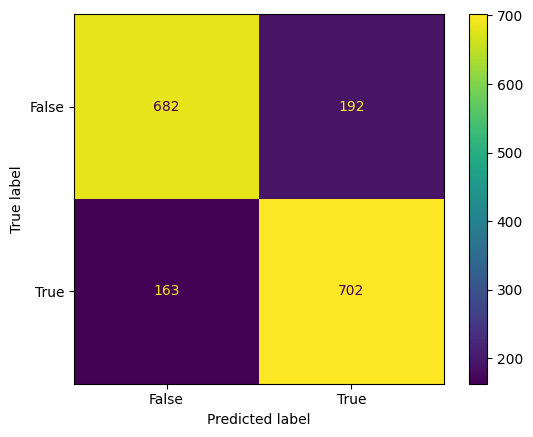

In [25]:
# Classification with Random forest

forest1= RandomForestClassifier(random_state= 24, criterion= 'entropy')

df2, report2, matrix2= allthings_fn("Random Forest", forest1, xtrain_done, ytrain, xval_done, yval)

df_good= pd.concat([df_good, df2], axis= 0)

# look at model performance
print(df_good)

print('-'*80)
print(report2)

print('-'*80)
print(matrix2)

Random forest is also overfit.

            Name  Train_accuracy  Train_F1  Val_accuracy    Val_F1
0         logreg        0.764452  0.752044      0.775733  0.763062
0  decision tree        0.930112  0.933461      0.751581  0.763676
0  Random Forest        0.930112  0.933967      0.795860  0.798181
0        XGBoost        0.883520  0.888491      0.788959  0.795771
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.81      0.75      0.78       874
        True       0.77      0.83      0.80       865

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

--------------------------------------------------------------------------------


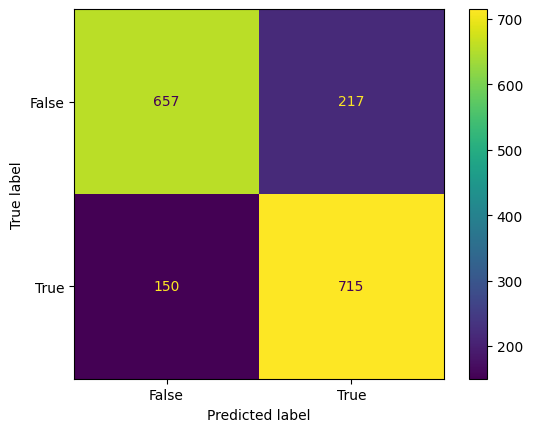

In [26]:
# Classification with xgboost

boost1= XGBClassifier(random_state= 24)

df3, report3, matrix3= allthings_fn("XGBoost", boost1, xtrain_done, ytrain, xval_done, yval)

df_good= pd.concat([df_good, df3], axis= 0)

# look at model performance
print(df_good)

print('-'*80)
print(report3)

print('-'*80)
print(matrix3)

Less overfit, but still not great accuracy

Random forest and xgboost had highest accuracy so try hyperparameter tuning.

forest with n_estimators 100, max_features 5 has val accuracy 0.7952846463484762
forest with n_estimators 100, max_features 10 has val accuracy 0.8010350776308223


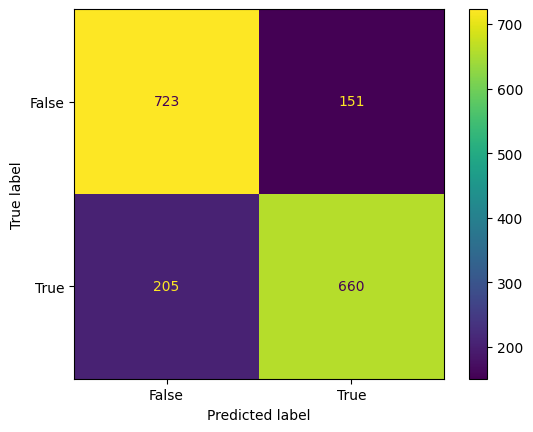

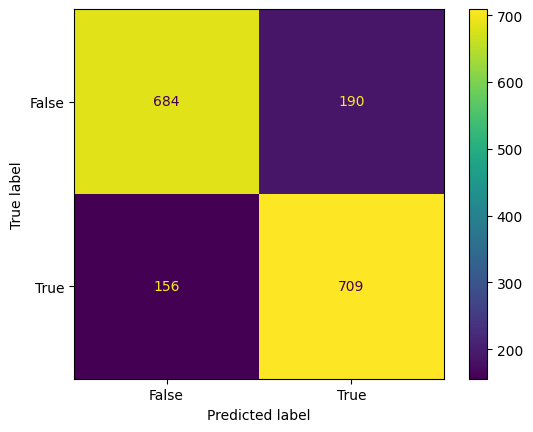

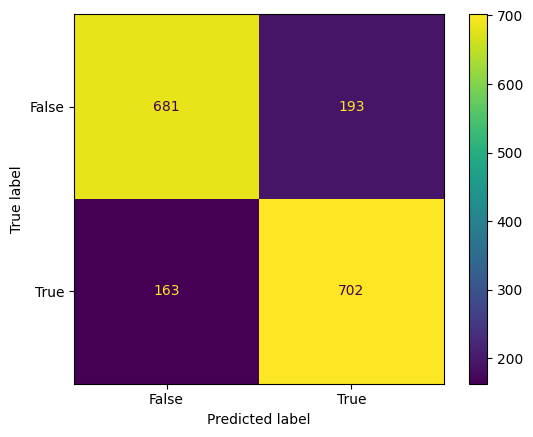

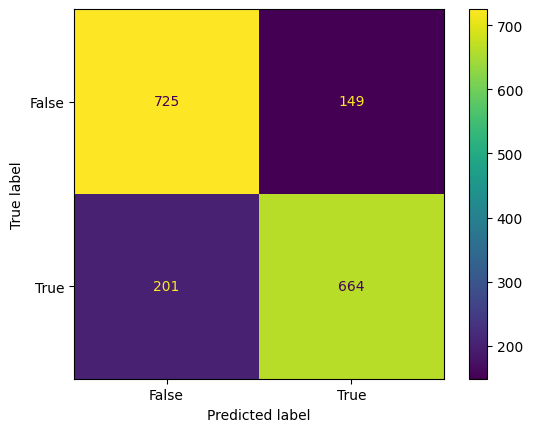

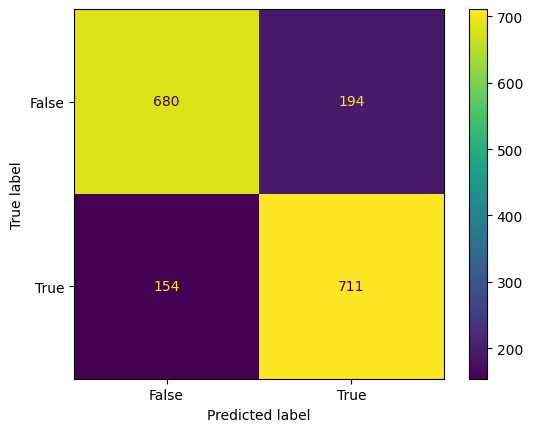

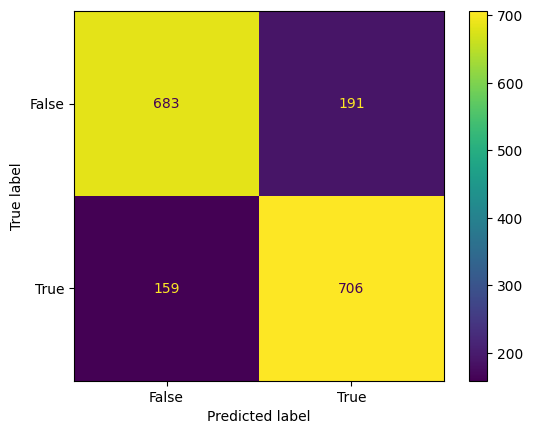

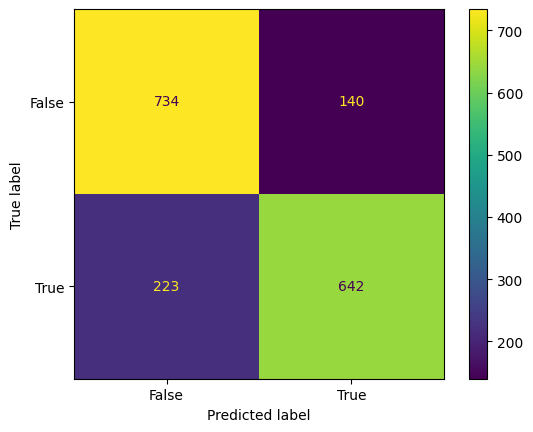

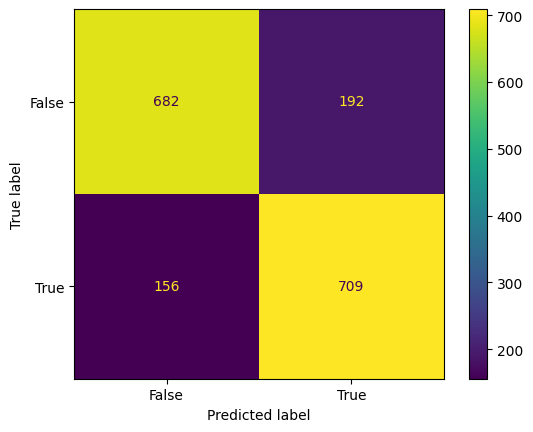

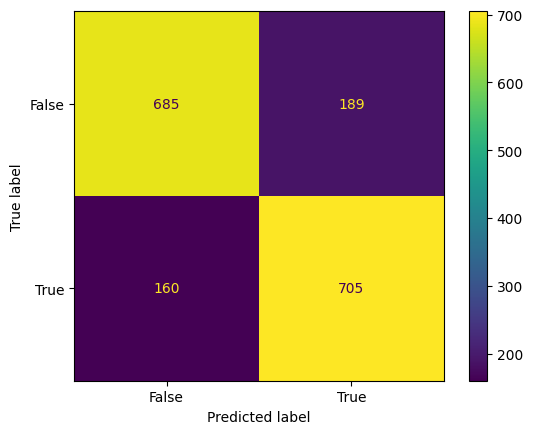

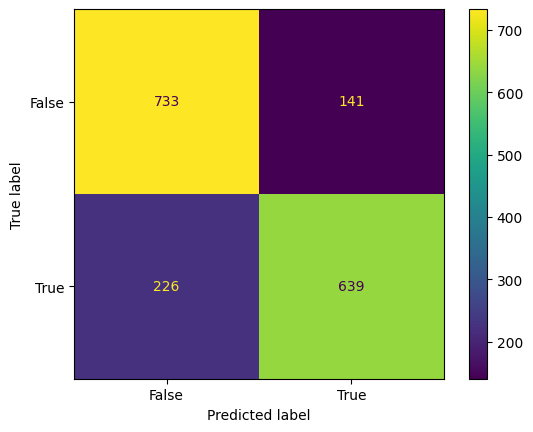

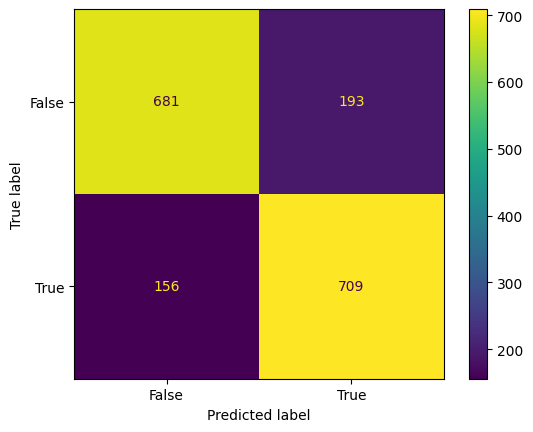

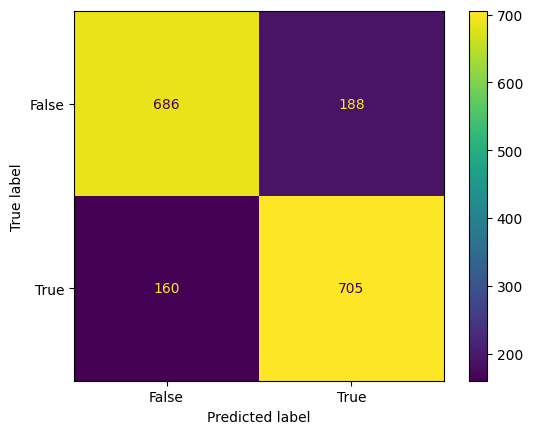

In [27]:
# hyperparameter tuning- random forest
params= {'n_estimators':[100, 250, 500, 750], 'max_depth':[5, 10, 15]}

acc= 0.5
i= 0 
j= 0 
for i in range(4):
    for j in range(3):
        # fit and evaluate model
        forest2= RandomForestClassifier(random_state= 24, criterion= 'entropy', n_estimators= params['n_estimators'][i], max_depth= params['max_depth'][j])
        df10, report10, matrix10= allthings_fn("opt random forest", forest2, xtrain_done, ytrain, xval_done, yval)
        # if model has higher accuracy save max depth and n estimators
        if df10.loc[0, 'Val_accuracy'] > acc:
            acc= df10.loc[0, 'Val_accuracy']
            # optimized n estimators
            best_est= params['n_estimators'][i]
            # optimized tree depth
            best_depth= params['max_depth'][j]
            print('forest with n_estimators {}, max_features {} has val accuracy {}'.format(best_est, best_depth, acc))

                Name  Train_accuracy  Train_F1  Val_accuracy    Val_F1
0             logreg        0.764452  0.752044      0.775733  0.763062
0      decision tree        0.930112  0.933461      0.751581  0.763676
0      Random Forest        0.930112  0.933967      0.795860  0.798181
0            XGBoost        0.883520  0.888491      0.788959  0.795771
0  opt Random Forest        0.843256  0.846479      0.801035  0.803855
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.81      0.78      0.80       874
        True       0.79      0.82      0.80       865

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739

--------------------------------------------------------------------------------


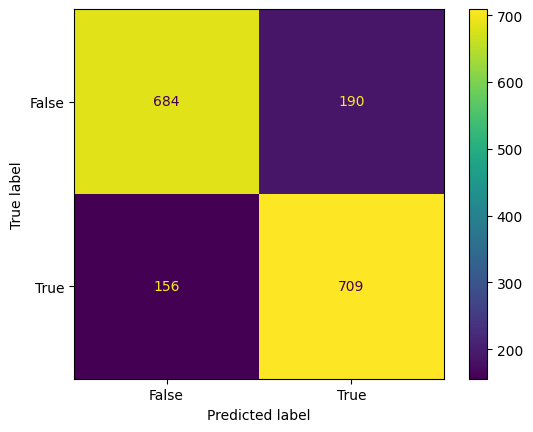

In [28]:
# Classification with optimized random forest

forest3= RandomForestClassifier(random_state= 24, criterion= 'entropy', n_estimators= best_est, max_depth= best_depth)

df5, report5, matrix5= allthings_fn("opt Random Forest", forest3, xtrain_done, ytrain, xval_done, yval)

df_good= pd.concat([df_good, df5], axis= 0)

# look at model performance
print(df_good)

print('-'*80)
print(report5)

print('-'*80)
print(matrix5)

Optimized random forest has improved accuracy and f1 score.  it is also no longer overfit.

forest with eta 0.002, n_estimators 100, has val accuracy 0.7929844738355377
forest with eta 0.002, n_estimators 250, has val accuracy 0.7947096032202415
forest with eta 0.002, n_estimators 500, has val accuracy 0.8067855089131685
forest with eta 0.005, n_estimators 250, has val accuracy 0.8079355951696378


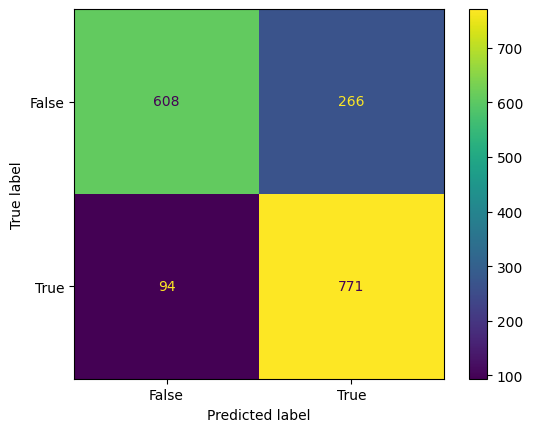

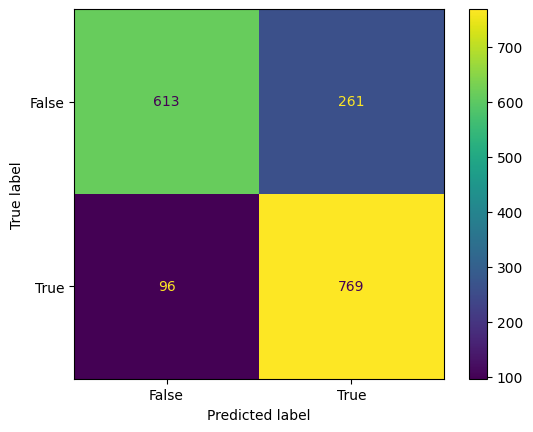

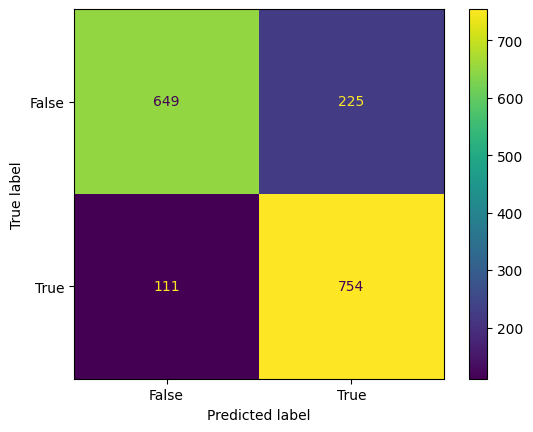

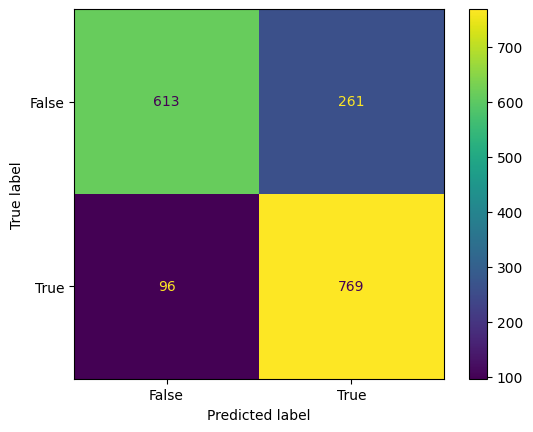

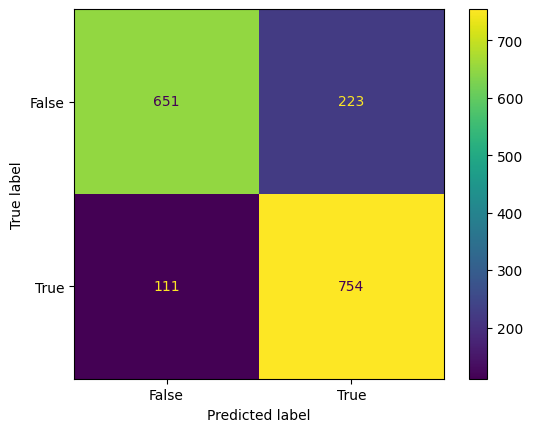

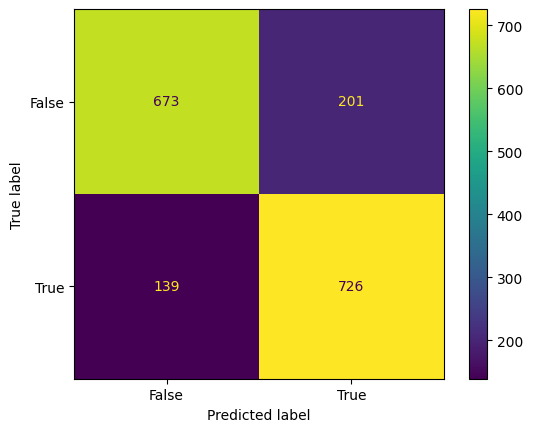

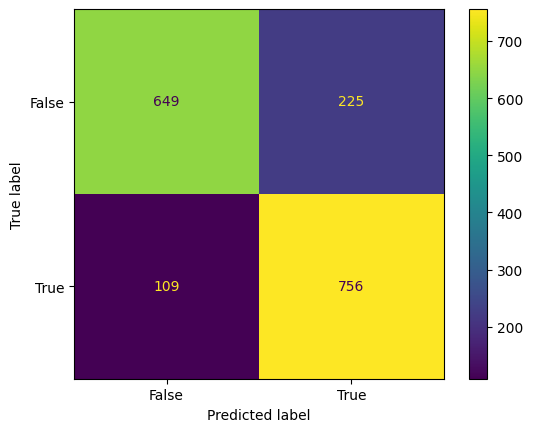

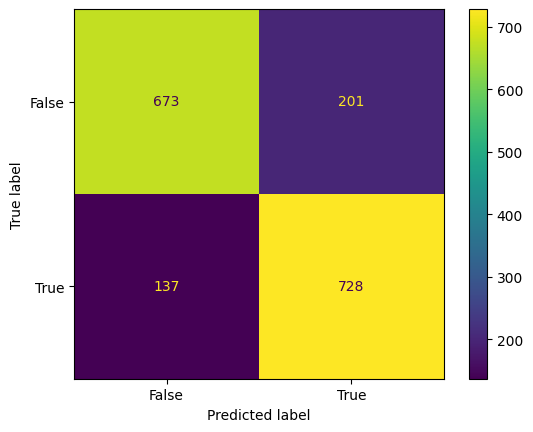

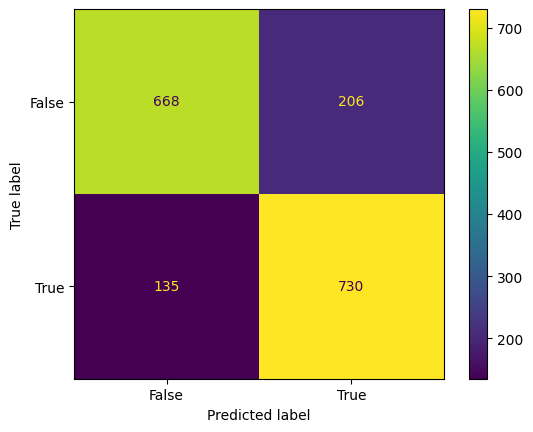

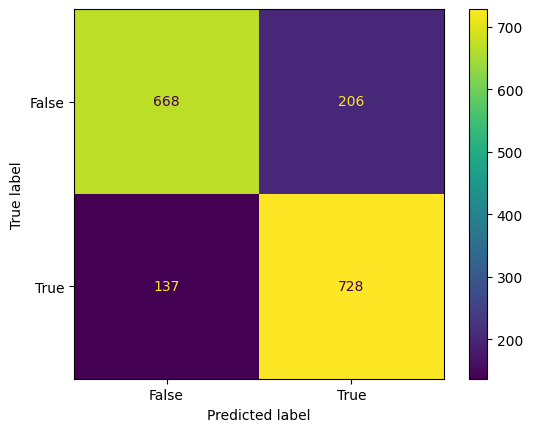

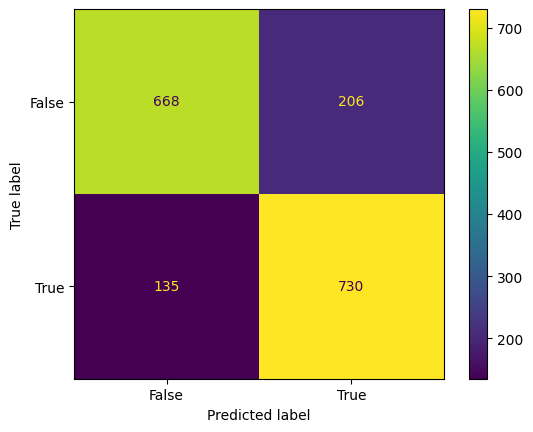

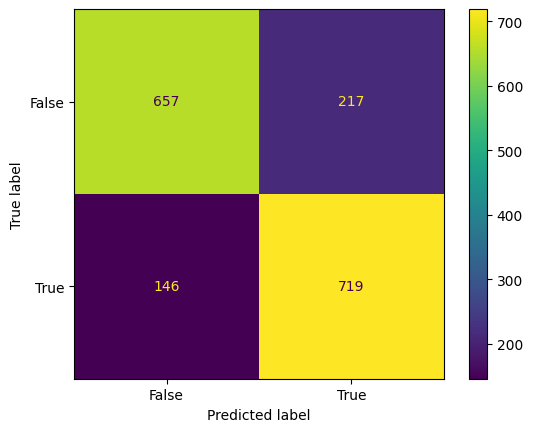

In [29]:
# hyperparameter tune xgboost: eta and n estimators

params2= {'eta':[0.002, 0.005, 0.01, 0.05], 'n_estimators':[100, 250, 500]}

acc= 0.5
i= 0 
j= 0
for i in range(4):
    for j in range(3):
        # fit and evaluate model
        boost2= XGBClassifier(random_state= 24, eta= params2['eta'][i], n_estimators= params2['n_estimators'][j])
        df11, report11, matrix11= allthings_fn("opt xgboost", boost2, xtrain_done, ytrain, xval_done, yval)
        # if model has high accuracy then save eta and n estimators
        if df11.loc[0, 'Val_accuracy'] > acc:
            acc= df11.loc[0, 'Val_accuracy']
            # optimized eta
            best_eta2= params2['eta'][i]
            # optimized n estimators
            best_est2= params2['n_estimators'][j]
            print('forest with eta {}, n_estimators {}, has val accuracy {}'.format(best_eta2, best_est2, acc))

                Name  Train_accuracy  Train_F1  Val_accuracy    Val_F1
0             logreg        0.764452  0.752044      0.775733  0.763062
0      decision tree        0.930112  0.933461      0.751581  0.763676
0      Random Forest        0.930112  0.933967      0.795860  0.798181
0            XGBoost        0.883520  0.888491      0.788959  0.795771
0  opt Random Forest        0.843256  0.846479      0.801035  0.803855
0        opt XGBoost        0.800690  0.812297      0.807936  0.818675
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.85      0.74      0.80       874
        True       0.77      0.87      0.82       865

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739

--------------------------------------------------------------------------------


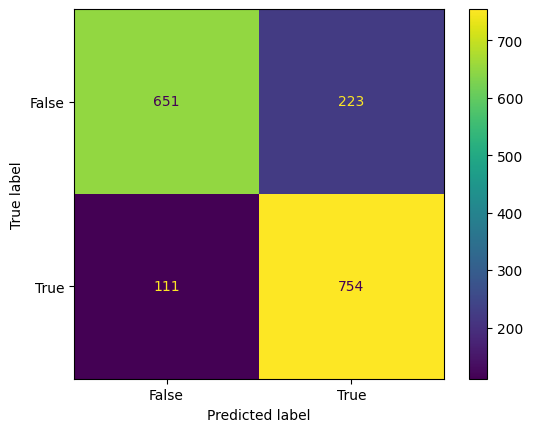

In [30]:
# Classification with optimized xgboost

boost3= XGBClassifier(random_state= 24, n_estimators= best_est2, eta= best_eta2)

df6, report6, matrix6= allthings_fn("opt XGBoost", boost3, xtrain_done, ytrain, xval_done, yval)

df_good= pd.concat([df_good, df6], axis= 0)

# look at model performance
print(df_good)

print('-'*80)
print(report6)

print('-'*80)
print(matrix6)

Best performance from optimized xgboost.  Now fit everything then predict on test and submit.

In [31]:
# use all of the training data
ytrain_all= train_df.loc[:, ['Transported']].reset_index(drop= True)
xtrain_all= train_df.drop(['Transported'], axis= 1).reset_index(drop= True)

# look at training dataframes
print('training features dataframe')
print(xtrain_all.head())
print('\n training target series')
print(ytrain_all.head())
print('\n test feature dataframe')
print(test_df.head())

training features dataframe
  HomePlanet CryoSleep  Destination   Age  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  
0           0.0     0.0     0.0  
1          25.0   549.0    44.0  
2           0.0  6715.0    49.0  
3         371.0  3329.0   193.0  
4         151.0   565.0     2.0  

 training target series
   Transported
0        False
1         True
2        False
3        False
4         True

 test feature dataframe
  HomePlanet CryoSleep  Destination   Age  RoomService  FoodCourt  \
0      Earth      True  TRAPPIST-1e  27.0          0.0        0.0   
1      Earth     False  TRAPPIST-1e  19.0          0.0        9.0   
2     

In [32]:
# check for null in training features
xtrain_all.isnull().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
dtype: int64

In [33]:
# separate numeric and categorical columns
num_col= xtrain_all.select_dtypes(include= np.number).columns.tolist()
str_col= xtrain_all.select_dtypes(exclude= np.number).columns.tolist()

# impute numeric columns with median
for i in num_col:
    mid1= xtrain_all[i].median()
    xtrain_all[i].fillna(mid1, inplace= True)
    test_df[i].fillna(mid1, inplace= True)

In [34]:
# scale the numeric columns

# initialize the scaler
scaler1= MinMaxScaler()

# scale the training
train_scale= scaler1.fit_transform(xtrain_all[num_col])
train_scale= pd.DataFrame(train_scale, columns= num_col)

# scale the test
test_scale= scaler1.transform(test_df[num_col])
test_scale= pd.DataFrame(test_scale, columns= num_col)

print('training scaled dataframe')
print(train_scale.head())
print('\ntest scaled dataframe')
print(test_scale.head())

training scaled dataframe
        Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck
0  0.493671     0.000000   0.000000      0.000000  0.000000  0.000000
1  0.303797     0.007608   0.000302      0.001064  0.024500  0.001823
2  0.734177     0.003001   0.119948      0.000000  0.299670  0.002030
3  0.417722     0.000000   0.043035      0.015793  0.148563  0.007997
4  0.202532     0.021149   0.002348      0.006428  0.025214  0.000083

test scaled dataframe
        Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck
0  0.341772     0.000000   0.000000       0.00000  0.000000  0.000000
1  0.240506     0.000000   0.000302       0.00000  0.125982  0.000000
2  0.392405     0.000000   0.000000       0.00000  0.000000  0.000000
3  0.481013     0.000000   0.223124       0.00000  0.008077  0.024241
4  0.253165     0.000698   0.000000       0.02703  0.000000  0.000000


In [35]:
# impute categorical using simple imputer and mode


# initialize imputer
imputer1= SimpleImputer(strategy= 'most_frequent')

# impute categorical column training
train_impute= imputer1.fit_transform(xtrain_all[str_col])
train_impute= pd.DataFrame(train_impute, columns= str_col)


# impute categorical column test
test_impute= imputer1.transform(test_df[str_col])
test_impute= pd.DataFrame(test_impute, columns= str_col)

# check for null in training
print("number of null for train is:{}".format(train_impute.isnull().sum().sum()))
# check for null in validation
print("number of null for test is:{}".format(test_impute.isnull().sum().sum()))

number of null for train is:0
number of null for test is:0


In [36]:
# one hot encode


# initialize one hot encoder
encoder1= OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')

# fit training
train_encode= encoder1.fit_transform(train_impute) 
train_encode= pd.DataFrame(train_encode, columns= encoder1.get_feature_names_out())
# combine numeric and string
train_final= pd.concat([train_scale, train_encode], axis= 1)

# fit test
test_encode= encoder1.transform(test_impute) 
test_encode= pd.DataFrame(test_encode, columns= encoder1.get_feature_names_out())
# combine numeric and string
test_final= pd.concat([test_scale, test_encode], axis= 1)

# look at encoded training dataframe
print('training encoded dataframe')
print(train_final.head())
# look at encoded test dataframe
print('\ntest encoded dataframe')
print(test_final.head())

# get shape for training and test
print('shape of training features is :{}'.format(train_final.shape))
print('shape of training target is :{}'.format(ytrain_all.shape))
print('shape of test features is :{}'.format(test_final.shape))

training encoded dataframe
        Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0  0.493671     0.000000   0.000000      0.000000  0.000000  0.000000   
1  0.303797     0.007608   0.000302      0.001064  0.024500  0.001823   
2  0.734177     0.003001   0.119948      0.000000  0.299670  0.002030   
3  0.417722     0.000000   0.043035      0.015793  0.148563  0.007997   
4  0.202532     0.021149   0.002348      0.006428  0.025214  0.000083   

   HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  CryoSleep_False  \
0               0.0                1.0              0.0              1.0   
1               1.0                0.0              0.0              1.0   
2               0.0                1.0              0.0              1.0   
3               0.0                1.0              0.0              1.0   
4               1.0                0.0              0.0              1.0   

   CryoSleep_True  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0   

In [37]:
# predict using optimized xgboost model


# optimized xgboost model using eta and n estimators from hyperparameter tuning
xgboost_opt= XGBClassifier(random_state= 24, n_estimators= best_est2, eta= best_eta2)

# fit model on full training dataset
xgboost_opt.fit(train_final, ytrain_all)

# predict test
y_pred_test= xgboost_opt.predict(test_final)
# convert to dataframe
y_pred_test= pd.Series(y_pred_test, name= 'Transported').astype(bool)

# combine id and predict to make submission file
y_test_final= pd.concat([test_id, y_pred_test], axis= 1)

# export predictions
y_test_final.to_csv('/kaggle/working/submission.csv', index= False)

print(y_test_final.head())

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
